In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d

In [2]:
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [10]:
player_id = find_players_by_full_name("Russell Westbrook")[0]['id']

In [4]:
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs

In [14]:
westbrook_scoring = PlayerGameLogs(measure_type_player_game_logs_nullable='Scoring', player_id_nullable=player_id, season_nullable='2019-20')

In [43]:
westbrook_normal = PlayerGameLogs(player_id_nullable=player_id, season_nullable='2019-20')

In [46]:
westbrook_normal_df = westbrook_normal.get_data_frames()[0]

In [15]:
westbrook_df = westbrook_scoring.get_data_frames()[0]

In [49]:
westbrook_df.columns

Index(['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT',
       'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT',
       'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM',
       'PCT_AST_3PM', 'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM', 'GP_RANK',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PCT_FGA_2PT_RANK',
       'PCT_FGA_3PT_RANK', 'PCT_PTS_2PT_RANK', 'PCT_PTS_2PT_MR_RANK',
       'PCT_PTS_3PT_RANK', 'PCT_PTS_FB_RANK', 'PCT_PTS_FT_RANK',
       'PCT_PTS_OFF_TOV_RANK', 'PCT_PTS_PAINT_RANK', 'PCT_AST_2PM_RANK',
       'PCT_UAST_2PM_RANK', 'PCT_AST_3PM_RANK', 'PCT_UAST_3PM_RANK',
       'PCT_AST_FGM_RANK', 'PCT_UAST_FGM_RANK'],
      dtype='object')

In [81]:
merged_df = pd.merge(left=westbrook_normal_df, right=westbrook_df, on=('SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'GAME_DATE', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'MATCHUP', 'WL'))

## Calculating the total ratio of points

In [82]:
merged_df = merged_df.sort_values(by='GAME_DATE')

In [83]:
merged_df.loc[:, 'PTS_FROM_3PT'] = merged_df.PTS * merged_df.PCT_PTS_3PT
merged_df.loc[:, 'PTS_FROM_2PT_MR'] = merged_df.PTS * merged_df.PCT_PTS_2PT_MR
merged_df.loc[:, 'PTS_FROM_PAINT'] = merged_df.PTS * merged_df.PCT_PTS_PAINT
merged_df.loc[:, 'PTS_FROM_FT'] = merged_df.PTS * merged_df.PCT_PTS_FT

In [84]:
merged_df.loc[:, 'PTS_FROM_3PT_CUMSUM'] = merged_df.PTS_FROM_3PT.cumsum()
merged_df.loc[:, 'PTS_FROM_2PT_MR_CUMSUM'] = merged_df.PTS_FROM_2PT_MR.cumsum()
merged_df.loc[:, 'PTS_FROM_PAINT_CUMSUM'] = merged_df.PTS_FROM_PAINT.cumsum()
merged_df.loc[:, 'PTS_FROM_FT_CUMSUM'] = merged_df.PTS_FROM_FT.cumsum()
merged_df.loc[:, 'PTS_CUMSUM'] = merged_df.PTS.cumsum()

In [85]:
merged_df.loc[:, 'PTS_FROM_3PT_CUMSUM_PCT'] = merged_df.PTS_FROM_3PT_CUMSUM / merged_df.PTS_CUMSUM
merged_df.loc[:, 'PTS_FROM_2PT_MR_CUMSUM_PCT'] = merged_df.PTS_FROM_2PT_MR_CUMSUM / merged_df.PTS_CUMSUM
merged_df.loc[:, 'PTS_FROM_PAINT_CUMSUM_PCT'] = merged_df.PTS_FROM_PAINT_CUMSUM / merged_df.PTS_CUMSUM
merged_df.loc[:, 'PTS_FROM_FT_CUMSUM_PCT'] = merged_df.PTS_FROM_FT_CUMSUM / merged_df.PTS_CUMSUM

In [24]:
plt.style.use('fivethirtyeight')

In [86]:

game_dates = [item.split("T")[0] for item in merged_df.GAME_DATE.tolist()]

In [121]:
bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'

In [128]:
westbrook_df.PLAYER_ID.unique()

array([201566], dtype=int64)

In [129]:
url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/1610612745/2019/260x190/201566.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))


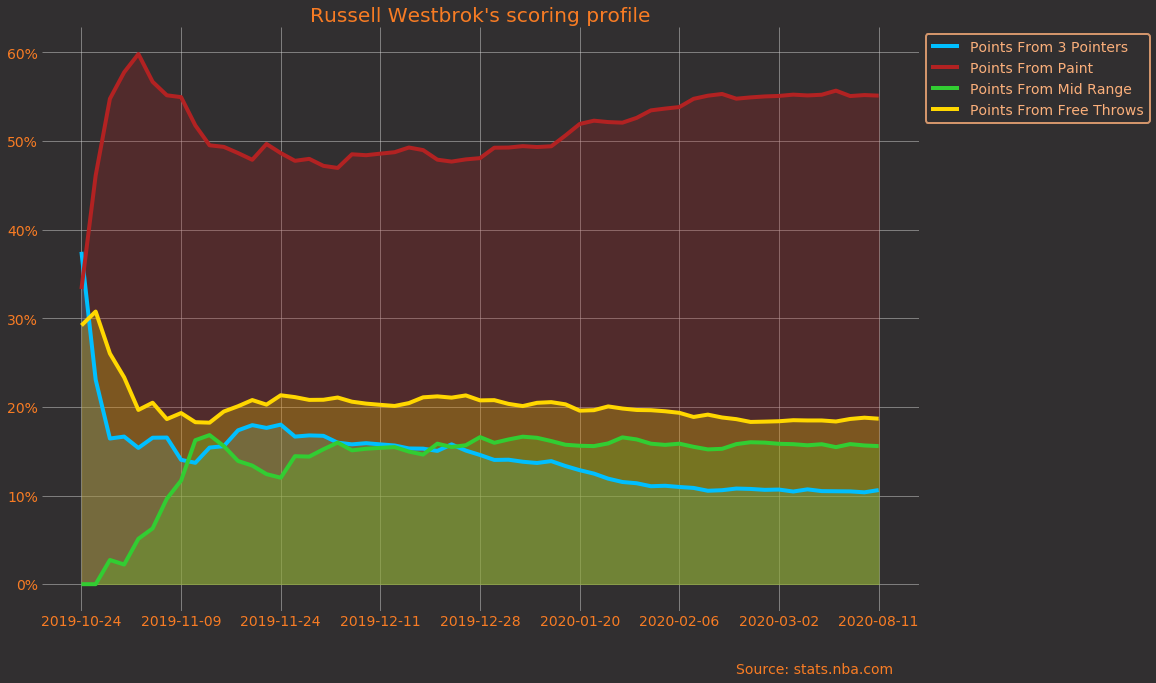

In [135]:

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(game_dates, merged_df.PTS_FROM_3PT_CUMSUM_PCT, label='Points From 3 Pointers', color='deepskyblue')
ax.fill_between(game_dates, merged_df.PTS_FROM_3PT_CUMSUM_PCT, color='deepskyblue', alpha=0.25)
ax.plot(game_dates, merged_df.PTS_FROM_PAINT_CUMSUM_PCT, label='Points From Paint', color='firebrick')
ax.fill_between(game_dates, merged_df.PTS_FROM_PAINT_CUMSUM_PCT, color='firebrick', alpha=0.25)
ax.plot(game_dates, merged_df.PTS_FROM_2PT_MR_CUMSUM_PCT, label='Points From Mid Range', color='limegreen')
ax.fill_between(game_dates, merged_df.PTS_FROM_2PT_MR_CUMSUM_PCT, color='limegreen', alpha=0.25)
ax.plot(game_dates, merged_df.PTS_FROM_FT_CUMSUM_PCT, label='Points From Free Throws', color='gold')
ax.fill_between(game_dates, merged_df.PTS_FROM_FT_CUMSUM_PCT, color='gold', alpha=0.25)

ax.set_xticks(ticks=[index for index in range(0, len(game_dates), 7)])
ax.set_xticklabels([game_dates[i] for i in range(0, len(game_dates), 7)])
ax.set_yticklabels([f"{item}%" for item in range(-10, 70, 10)])

ax.set_title("Russell Westbrok's scoring profile", color=bball_orange)
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.text(57, -0.1, s='Source: stats.nba.com', ha='right', color=bball_orange)


ax.grid(alpha=0.5)
ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_orange)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_orange)
#ax.set_yticklabels(f"{item}%" for item in range(5, 35, 5))
    
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)

ax.set_frame_on(False)
ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)


In [137]:
merged_df.loc[:, 'FG2A'] = merged_df.FGA * merged_df.PCT_FGA_2PT

In [139]:
merged_df.loc[:, 'FGA_CUMSUM'] = merged_df.FGA.cumsum()
merged_df.loc[:, 'FG3A_CUMSUM'] = merged_df.FG3A.cumsum()
merged_df.loc[:, 'FG2A_CUMSUM'] = merged_df.FG2A.cumsum()

In [140]:
merged_df.loc[:, 'FG3A_PCT'] = merged_df.FG3A_CUMSUM / merged_df.FGA_CUMSUM
merged_df.loc[:, 'FG2A_PCT'] = merged_df.FG2A_CUMSUM / merged_df.FGA_CUMSUM

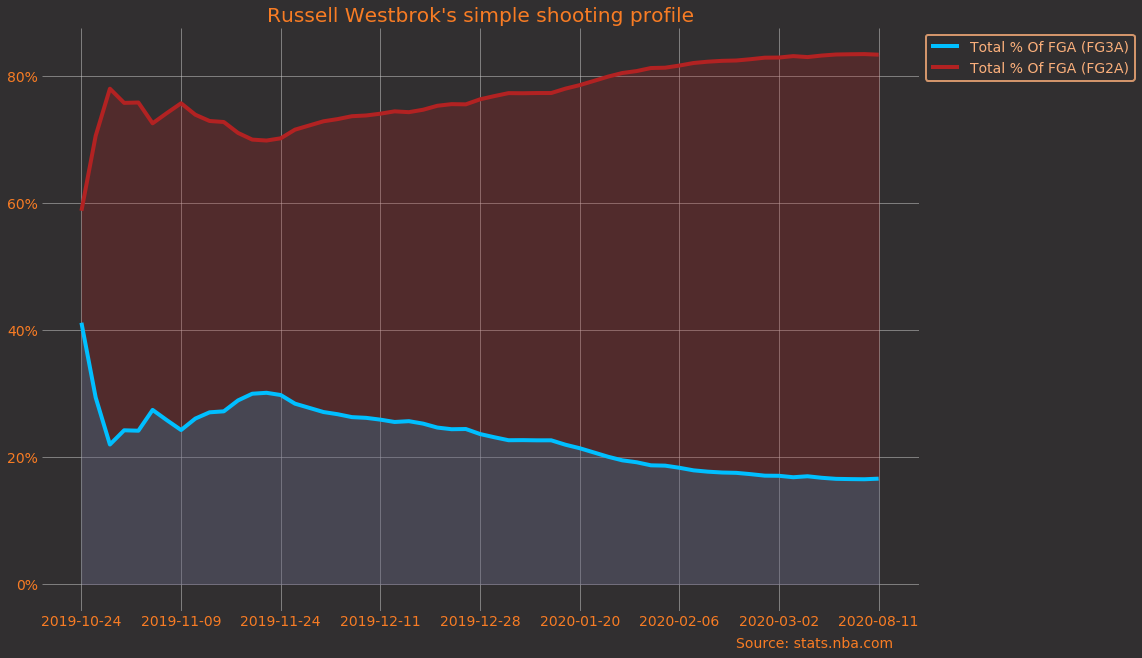

In [146]:

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(game_dates, merged_df.FG3A_PCT, label='Total % Of FGA (FG3A)', color='deepskyblue')
ax.fill_between(game_dates, merged_df.FG3A_PCT, color='deepskyblue', alpha=0.25)
ax.plot(game_dates, merged_df.FG2A_PCT, label='Total % Of FGA (FG2A)', color='firebrick')
ax.fill_between(game_dates, merged_df.FG2A_PCT, color='firebrick', alpha=0.25)


ax.set_xticks(ticks=[index for index in range(0, len(game_dates), 7)])
#ax.set_xticklabels([game_dates[i] for i in range(0, len(game_dates), 7)])
ax.set_yticklabels([f"{item}%" for item in range(-20, 100, 20)])

ax.set_title("Russell Westbrok's simple shooting profile", color=bball_orange)
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.text(57, -0.1, s='Source: stats.nba.com', ha='right', color=bball_orange)


ax.grid(alpha=0.5)
ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_orange)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_orange)
#ax.set_yticklabels(f"{item}%" for item in range(5, 35, 5))
    
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)

ax.set_frame_on(False)
ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)


In [147]:
westbrook_shot = ShotChartDetail(team_id=0, player_id=player_id, season_nullable='2019-20', season_type_all_star='Regular Season', context_measure_simple='FGA')

In [148]:
shot_df = westbrook_shot.get_data_frames()[0]

In [157]:
shot_df.SHOT_ZONE_BASIC

0       Above the Break 3
1               Mid-Range
2         Restricted Area
3       Above the Break 3
4         Restricted Area
              ...        
1276    Above the Break 3
1277      Restricted Area
1278            Mid-Range
1279    Above the Break 3
1280      Restricted Area
Name: SHOT_ZONE_BASIC, Length: 1281, dtype: object

In [160]:
grouped = shot_df.groupby('GAME_DATE').SHOT_ZONE_BASIC.value_counts()

In [188]:
unstacked = grouped.unstack(fill_value=0)

In [189]:
unstacked = unstacked.rename(
    columns={
        "Above the Break 3": "ABOVE_THE_BREAK_3",
        "In The Paint (Non-RA)": "IN_THE_PAINT_NON_RA",
        "Left Corner 3": "LEFT_CORNER_3",
        "Right Corner 3": "RIGHT_CORNER_3",
        "Mid-Range": "MID_RANGE",
        "Restricted Area": "RESTRICTED_AREA",
    }
)

In [190]:
unstacked.loc[:, 'TOTAL_FGA'] = unstacked.sum(axis=1)

In [200]:
cumulative_sums = unstacked.cumsum()

In [201]:
cumulative_sums.loc[:, 'CORNER_3'] = cumulative_sums.LEFT_CORNER_3 + cumulative_sums.RIGHT_CORNER_3

In [202]:
target_columns = ['ABOVE_THE_BREAK_3', 'IN_THE_PAINT_NON_RA', 'MID_RANGE', 'RESTRICTED_AREA', 'CORNER_3']

for column in target_columns:
    cumulative_sums.loc[:, f"{column}_PCT"] = cumulative_sums[column] / cumulative_sums.TOTAL_FGA

In [204]:
cumulative_sums.columns

Index(['ABOVE_THE_BREAK_3', 'IN_THE_PAINT_NON_RA', 'LEFT_CORNER_3',
       'MID_RANGE', 'RESTRICTED_AREA', 'RIGHT_CORNER_3', 'TOTAL_FGA',
       'CORNER_3', 'ABOVE_THE_BREAK_3_PCT', 'IN_THE_PAINT_NON_RA_PCT',
       'MID_RANGE_PCT', 'RESTRICTED_AREA_PCT', 'CORNER_3_PCT'],
      dtype='object', name='SHOT_ZONE_BASIC')

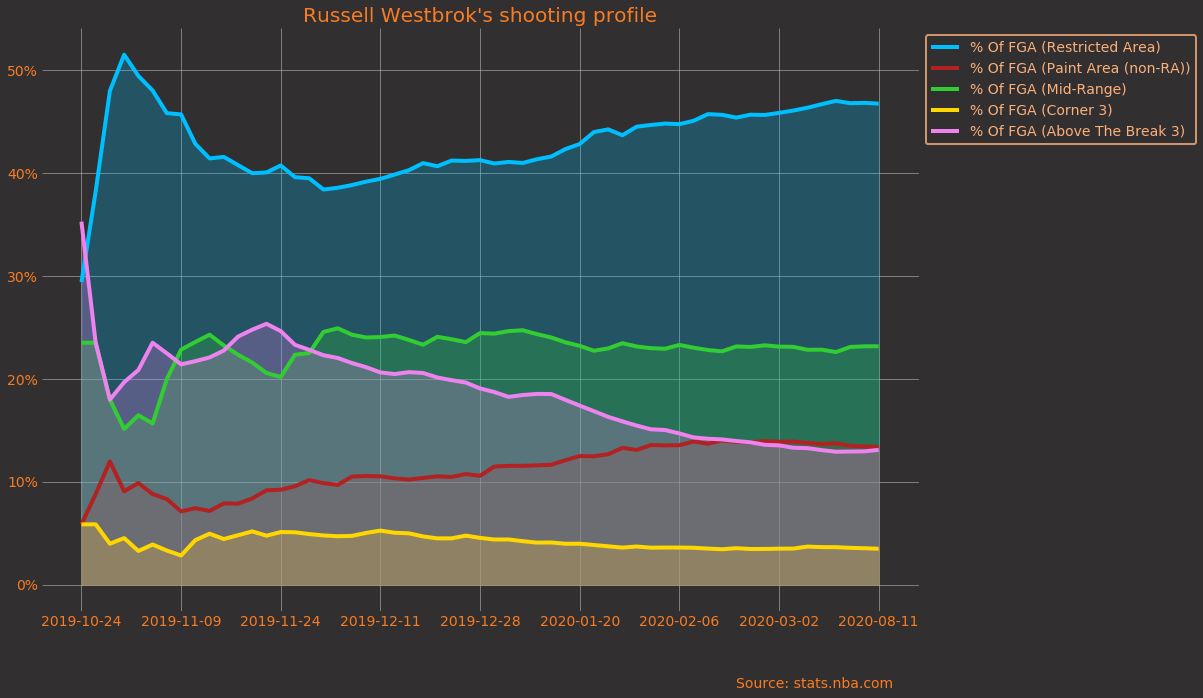

In [207]:

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(game_dates, cumulative_sums.RESTRICTED_AREA_PCT, label='% Of FGA (Restricted Area)', color='deepskyblue')
ax.fill_between(game_dates, cumulative_sums.RESTRICTED_AREA_PCT, color='deepskyblue', alpha=0.25)

ax.plot(game_dates, cumulative_sums.IN_THE_PAINT_NON_RA_PCT, label='% Of FGA (Paint Area (non-RA))', color='firebrick')
ax.fill_between(game_dates, cumulative_sums.IN_THE_PAINT_NON_RA_PCT, color='firebrick', alpha=0.25)

ax.plot(game_dates, cumulative_sums.MID_RANGE_PCT, label='% Of FGA (Mid-Range)', color='limegreen')
ax.fill_between(game_dates, cumulative_sums.MID_RANGE_PCT, color='limegreen', alpha=0.25)

ax.plot(game_dates, cumulative_sums.CORNER_3_PCT, label='% Of FGA (Corner 3)', color='gold')
ax.fill_between(game_dates, cumulative_sums.CORNER_3_PCT, color='gold', alpha=0.25)

ax.plot(game_dates, cumulative_sums.ABOVE_THE_BREAK_3_PCT, label='% Of FGA (Above The Break 3)', color='violet')
ax.fill_between(game_dates, cumulative_sums.ABOVE_THE_BREAK_3_PCT, color='violet', alpha=0.25)

ax.set_xticks(ticks=[index for index in range(0, len(game_dates), 7)])
ax.set_xticklabels([game_dates[i] for i in range(0, len(game_dates), 7)])
ax.set_yticklabels([f"{item}%" for item in range(-10, 60, 10)])

ax.set_title("Russell Westbrok's shooting profile", color=bball_orange)
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.text(57, -0.1, s='Source: stats.nba.com', ha='right', color=bball_orange)


ax.grid(alpha=0.5)
ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_orange)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_orange)
#ax.set_yticklabels(f"{item}%" for item in range(5, 35, 5))
    
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)

ax.set_frame_on(False)
ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
